In [1]:
import numpy as np
import xarray as xr
import pandas as pd
from salishsea_tools import viz_tools, places, visualisations
from matplotlib import pyplot as plt, dates
from datetime import datetime, timedelta
from calendar import month_name
from scipy.io import loadmat
from tqdm.notebook import tqdm
from salishsea_tools import nc_tools
from dask.diagnostics import ProgressBar
import cmocean
from scipy.stats import sem
import scipy.stats as stats

%matplotlib inline

In [2]:
plt.rcParams.update({'font.size': 12, 'axes.titlesize': 'medium'})

### Load files from monthly averages

In [3]:
# Load files for halocline depth and halocline strength

monthly_array_halocline_depth_SSslice = np.zeros([14,12,50,50])
monthly_array_halocline_strength_SSslice = np.zeros([14,12,50,50])

mask = xr.open_dataset('/data/eolson/results/MEOPAR/NEMO-forcing-new/grid/mesh_mask201702.nc')
slc = {'y': slice(450,500), 'x': slice(250,300)} 
e3t, tmask,depth = [mask[var].isel(**slc).values for var in ('e3t_0', 'tmask','gdept_0')]
years, variables = range(2007, 2021), ['halocline','strength']


# Temporary list dict
data = {}

# Permanent aggregate dict
aggregates = {var: {} for var in variables}

# Loop through years
for year in [2007,2008,2009,2010,2011,2012,2015,2016,2017,2018,2019,2020]:
    # Initialize lists
    for var in variables: data[var] = []
    # Load monthly averages
    for month in range(1, 13):
        datestr = f'{year}{month:02d}'
        prefix = f'/data/sallen/results/MEOPAR/v201905r/SalishSea_1m_{datestr}_{datestr}'
        
        
        # Load grazing variables
        with xr.open_dataset(prefix + '_grid_T.nc') as ds:
            q = ds.vosaline.isel(deptht=0, **slc).values
            q2 = q[0,:,:]
            monthly_array_halocline_depth_SSslice[year-2007,month-1,:,:] = q2 #year2007 is index 0 along 1st dimension
            
            sal=ds.vosaline.isel(**slc).values
                      
             #get the gradient in salinity
            sal_grad = np.zeros_like(sal)

            for i in range(0, (np.shape(sal_grad)[1]-1)):
                sal_grad[:,i,:,:] =(sal[:,i,:,:]-sal[:,i+1,:,:])/(depth[:,i,:,:]-depth[:,i+1,:,:])

            #print(sal_grad)

            loc_max = np.argmax(sal_grad,axis=1)
            depths=np.tile(depth,[np.shape(sal)[0],1,1,1])
            h1=np.take_along_axis(depths, np.expand_dims(loc_max, axis=1), axis=1)
            h2=np.take_along_axis(depths, np.expand_dims(loc_max+1, axis=1), axis=1)
            
            sals=np.tile(sal,[np.shape(sal)[0],1,1,1])
            s1=np.take_along_axis(sals, np.expand_dims(loc_max, axis=1), axis=1)
            s2=np.take_along_axis(sals, np.expand_dims(loc_max+1, axis=1), axis=1)

            #halocline is halfway between the two cells
            halocline = 0.5*(h1+h2)
            strength = (s2-s1)/(h2-h1)
        
            data['halocline'].append(halocline)
            data['strength'].append(strength)
                        
            monthly_array_halocline_depth_SSslice[year-2007,month-1,:,:]=halocline
            monthly_array_halocline_strength_SSslice[year-2007,month-1,:,:]=strength
            

# Loop through years for wrap files
for year in [2013,2014]:
    # Initialize lists
    for var in variables: data[var] = []
    # Load monthly averages
    for month in range(1, 13):
        datestr = f'{year}{month:02d}'
        prefix = f'/data/sallen/results/MEOPAR/v201905r_wrap/SalishSea_1m_{datestr}_{datestr}'            
        
         # Load grazing variables
        with xr.open_dataset(prefix + '_grid_T.nc') as ds:
            q = ds.vosaline.isel(deptht=0, **slc).values
            q2 = q[0,:,:]
            monthly_array_halocline_depth_SSslice[year-2007,month-1,:,:] = q2 #year2007 is index 0 along 1st dimension
            
            sal=ds.vosaline.isel(**slc).values
                      
             #get the gradient in salinity
            sal_grad = np.zeros_like(sal)

            for i in range(0, (np.shape(sal_grad)[1]-1)):
                sal_grad[:,i,:,:] =(sal[:,i,:,:]-sal[:,i+1,:,:])/(depth[:,i,:,:]-depth[:,i+1,:,:])

            #print(sal_grad)

            loc_max = np.argmax(sal_grad,axis=1)
            depths=np.tile(depth,[np.shape(sal)[0],1,1,1])
            h1=np.take_along_axis(depths, np.expand_dims(loc_max, axis=1), axis=1)
            h2=np.take_along_axis(depths, np.expand_dims(loc_max+1, axis=1), axis=1)
            
            sals=np.tile(sal,[np.shape(sal)[0],1,1,1])
            s1=np.take_along_axis(sals, np.expand_dims(loc_max, axis=1), axis=1)
            s2=np.take_along_axis(sals, np.expand_dims(loc_max+1, axis=1), axis=1)

            #halocline is halfway between the two cells
            halocline = 0.5*(h1+h2)
            strength = (s2-s1)/(h2-h1)
        
            data['halocline'].append(halocline)
            data['strength'].append(strength)
                        
            monthly_array_halocline_depth_SSslice[year-2007,month-1,:,:]=halocline
            monthly_array_halocline_strength_SSslice[year-2007,month-1,:,:]=strength
            
#    # Concatenate months
#    for var in variables: aggregates[var][year] = np.concatenate(data[var]).mean(axis=0)

#Calculate climatological mean and anomalies
#for var in variables:
#    aggregates[var]['mean'] = np.concatenate([aggregates[var][year][None, ...] for year in years]).mean(axis=0)
#    for year in years: aggregates[var][year] = aggregates[var][year] - aggregates[var]['mean']

In [4]:
print(np.shape(monthly_array_halocline_depth_SSslice))

(14, 12, 50, 50)


In [5]:
print(np.shape(monthly_array_halocline_strength_SSslice))

(14, 12, 50, 50)


In [6]:
monthly_array_halocline_strength_SSslice.mean()

1.2339988562810367

# Halocline Strength

In [7]:
monthly_array_halocline_strength_SSslice[monthly_array_halocline_strength_SSslice == 0 ] = np.nan
monthly_array_halocline_strength_SSslicemean = \
np.nanmean(np.nanmean(monthly_array_halocline_strength_SSslice, axis = 2),axis = 2)
print(np.shape(monthly_array_halocline_strength_SSslicemean))

(14, 12)


### Plot Seasonal Cycles for Individual Years

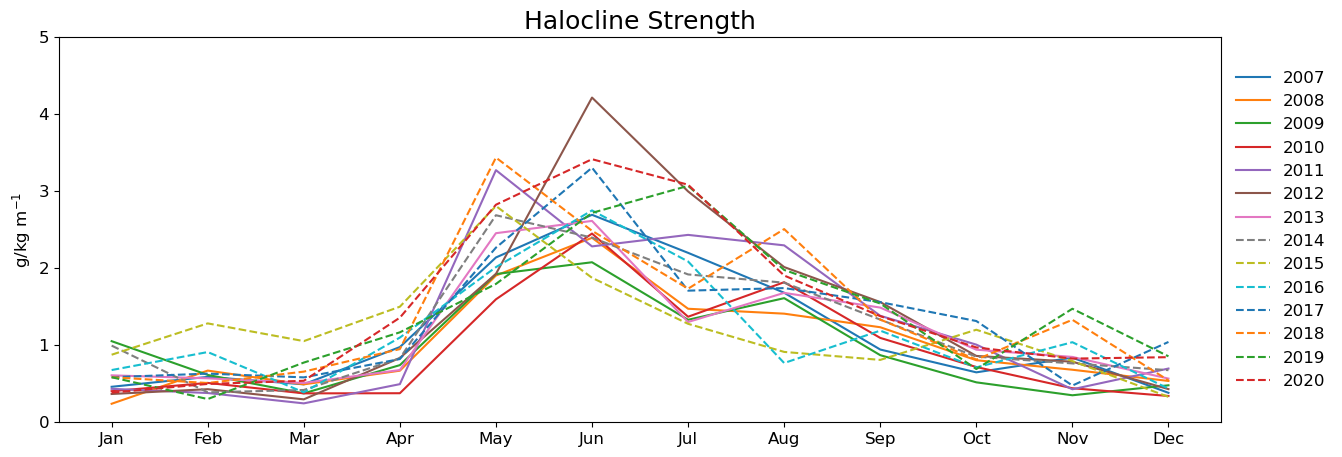

In [8]:
#plot monthly means for 5 years
fig, ax = plt.subplots(figsize=(15, 5))
bbox = {'boxstyle': 'round', 'facecolor': 'w', 'alpha': 0.9}
cmap = plt.get_cmap('tab10')
palette = [cmap(0), cmap(0.2), 'k', cmap(0.1), cmap(0.3)]
xticks=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov',"Dec"]

for i in range(0,7):
    ax.plot(xticks, monthly_array_halocline_strength_SSslicemean[i,:],label=2007+i)
    ax.set_title('Central SoG Halocline',fontsize=18)
    ax.legend(frameon=False)
    ax.set_ylim(0,55)
    ax.set_ylabel('')
    #ax.invert_yaxis()
   
for i in range(7,14):
    ax.plot(xticks, monthly_array_halocline_strength_SSslicemean[i,:],linestyle='--',label=2007+i)
    ax.set_title('Halocline Strength',fontsize=18)
    ax.legend(frameon=False,loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_ylim(0,5)
    ax.set_ylabel('g/kg m$^{-1}$')
    #ax.invert_yaxis()

### Select 4 warmest and 4 coldest years; leave NPGO "neutral" years out

In [9]:
#2008, 2010, 2011, 2012
NPGO_C_Strength=(((+monthly_array_halocline_strength_SSslicemean[1,:]+\
        monthly_array_halocline_strength_SSslicemean[3,:]+\
        monthly_array_halocline_strength_SSslicemean[4,:]+monthly_array_halocline_strength_SSslicemean[5,:])/4))

In [10]:
#2015, 2018, 2019, 2020
NPGO_W_Strength=(((monthly_array_halocline_strength_SSslicemean[8,:]+\
        monthly_array_halocline_strength_SSslicemean[11,:]+monthly_array_halocline_strength_SSslicemean[12,:]+\
        monthly_array_halocline_strength_SSslicemean[13,:])/4))

[Text(0, 0, ''),
 Text(1, 0, ''),
 Text(2, 0, ''),
 Text(3, 0, ''),
 Text(4, 0, ''),
 Text(5, 0, ''),
 Text(6, 0, ''),
 Text(7, 0, ''),
 Text(8, 0, ''),
 Text(9, 0, ''),
 Text(10, 0, ''),
 Text(11, 0, '')]

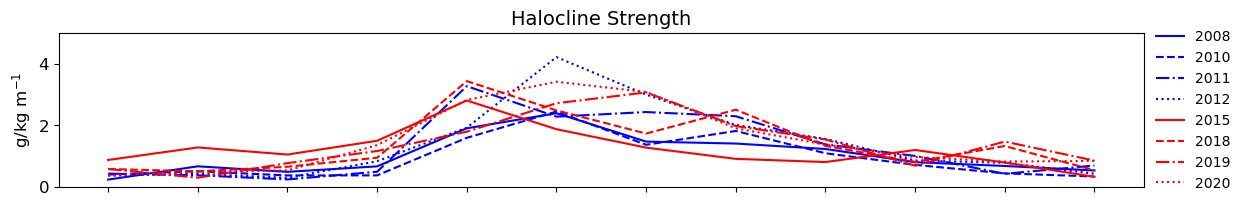

In [11]:
## Plot the coldest and warmest years only; Supp Fig. S3

fig, ax = plt.subplots(figsize=(14, 2))
bbox = {'boxstyle': 'round', 'facecolor': 'w', 'alpha': 0.9}
cmap = plt.get_cmap('tab10')
palette = [cmap(0), cmap(0.2), 'k', cmap(0.1), cmap(0.3)]
xticks=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov',"Dec"]

ax.plot(xticks, monthly_array_halocline_strength_SSslicemean[1,:],color='b',linestyle='-',label='2008')
ax.plot(xticks, monthly_array_halocline_strength_SSslicemean[3,:],color='b',linestyle='--',label='2010')
ax.plot(xticks, monthly_array_halocline_strength_SSslicemean[4,:],color='b',linestyle='-.',label='2011')
ax.plot(xticks, monthly_array_halocline_strength_SSslicemean[5,:],color='b',linestyle=':',label='2012')
ax.plot(xticks, monthly_array_halocline_strength_SSslicemean[8,:],color='r',linestyle='-',label='2015')
ax.plot(xticks, monthly_array_halocline_strength_SSslicemean[11,:],color='r',linestyle='--',label='2018')
ax.plot(xticks, monthly_array_halocline_strength_SSslicemean[12,:],color='r',linestyle='-.',label='2019')
ax.plot(xticks, monthly_array_halocline_strength_SSslicemean[13,:],color='r',linestyle=':',label='2020')

ax.set_title('Halocline Strength',fontsize=14)
ax.legend(frameon=False,loc='center left', bbox_to_anchor=(1, 0.5),fontsize=10)
ax.set_ylim(0,5)
ax.set_ylabel('g/kg m$^{-1}$')
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
ax.set_xticklabels([])

### Data for Figure 3: Calculate monthly standard error values for cold and warm years

In [12]:
NPGO_W_years=[monthly_array_halocline_strength_SSslicemean[8,:],monthly_array_halocline_strength_SSslicemean[11,:],monthly_array_halocline_strength_SSslicemean[12,:],monthly_array_halocline_strength_SSslicemean[13,:]]

In [13]:
sem(NPGO_W_years)

array([0.10139684, 0.21724346, 0.11031644, 0.11941914, 0.33992397,
       0.31827148, 0.46300932, 0.33271079, 0.15843871, 0.11012063,
       0.17339882, 0.12728148])

In [14]:
NPGO_W_SEM=[0.10139684, 0.21724346, 0.11031644, 0.11941914, 0.33992397,
       0.31827148, 0.46300932, 0.33271079, 0.15843871, 0.11012063,
       0.17339882, 0.12728148]

In [15]:
NPGO_C_years=[monthly_array_halocline_strength_SSslicemean[1,:],
        monthly_array_halocline_strength_SSslicemean[3,:],
        monthly_array_halocline_strength_SSslicemean[4,:],monthly_array_halocline_strength_SSslicemean[5,:]]

In [16]:
sem(NPGO_C_years)

array([0.0425931 , 0.06372294, 0.0536515 , 0.10031701, 0.37381109,
       0.46136078, 0.39131849, 0.18637298, 0.09991184, 0.06102145,
       0.08902362, 0.0766228 ])

In [17]:
NPGO_C_SEM=[0.0425931 , 0.06372294, 0.0536515 , 0.10031701, 0.37381109,
       0.46136078, 0.39131849, 0.18637298, 0.09991184, 0.06102145,
       0.08902362, 0.0766228]

In [18]:
NPGO_C_Strength

array([0.36154052, 0.49809309, 0.35279773, 0.59444239, 2.17599837,
       2.83692228, 2.06920697, 1.88577881, 1.31863951, 0.84843678,
       0.58477922, 0.50166281])

Text(-0.4, 3.2, '(c)')

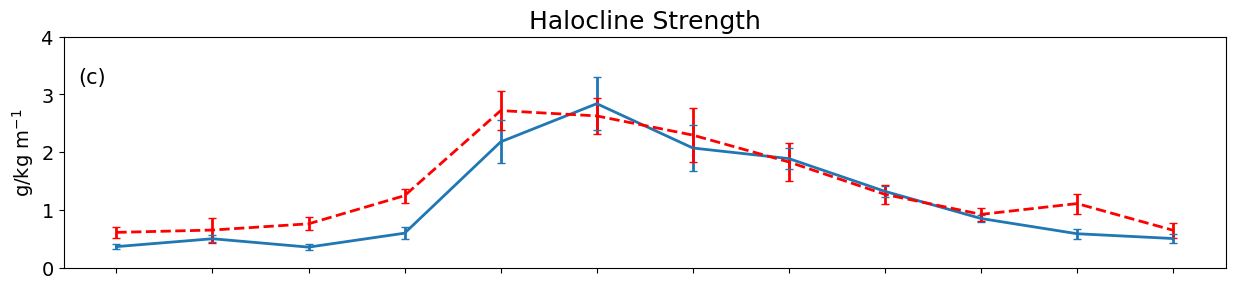

In [19]:
## Preliminary Figure 3c


fig, ax = plt.subplots(figsize=(15, 3))
bbox = {'boxstyle': 'round', 'facecolor': 'w', 'alpha': 0.9}
cmap = plt.get_cmap('tab10')
palette = [cmap(0), cmap(0.2), 'k', cmap(0.1), cmap(0.3)]
xticks=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov',"Dec"]

ax.errorbar(xticks, NPGO_C_Strength, yerr= NPGO_C_SEM, capsize=3,label='NPGO+ coldest',linewidth=2)
ax.errorbar(xticks, NPGO_W_Strength,yerr= NPGO_W_SEM, capsize=3,linestyle='--',label='NPGO- warmest',color='r',linewidth=2)
ax.set_title('Halocline Strength',fontsize=18)
ax.legend((),frameon=False,loc=1)
ax.set_ylim(0,4)
ax.set_ylabel('g/kg m$^{-1}$',fontsize=14)
#ax.invert_yaxis()
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
ax.set_xticklabels([])

a=2
b=5
c=5
d=8

ax.text(-.4, 3.2, '(c)', fontsize=15,  color='k')

#plt.fill([a, a, b, b], [0, 25, 25, 0], color = 'lightgreen', alpha = 0.1)
#plt.fill([c, c, d, d], [0, 25, 25, 0], color = 'wheat', alpha = 0.2)

#plt.savefig('Fig3c_Halocline.png', bbox_inches='tight',dpi=1000,transparent=False)

### Data for calculating seasonal mean values for box plots

In [20]:
Spring_C=(((monthly_array_halocline_strength_SSslicemean[(1,3,4,5),2]+
        monthly_array_halocline_strength_SSslicemean[(1,3,4,5),3]+monthly_array_halocline_strength_SSslicemean[(1,3,4,5),4]))/3) #

In [21]:
Spring_W=(((monthly_array_halocline_strength_SSslicemean[(8,11,12,13),2]+
        monthly_array_halocline_strength_SSslicemean[(8,11,12,13),3]+monthly_array_halocline_strength_SSslicemean[(8,11,12,13),4]))/3) #

In [22]:
Summer_C=(((monthly_array_halocline_strength_SSslicemean[(1,3,4,5),5]+
        monthly_array_halocline_strength_SSslicemean[(1,3,4,5),6]+monthly_array_halocline_strength_SSslicemean[(1,3,4,5),7]))/3) #

In [23]:
Summer_C

array([1.76022024, 1.88017547, 2.33848005, 3.07700164])

In [24]:
Summer_W=(((monthly_array_halocline_strength_SSslicemean[(8,11,12,13),5]+
        monthly_array_halocline_strength_SSslicemean[(8,11,12,13),6]+monthly_array_halocline_strength_SSslicemean[(8,11,12,13),7]))/3) #

In [25]:
Summer_W

array([1.3562591 , 2.24361753, 2.58961049, 2.80259067])

In [26]:
Summer_C

array([1.76022024, 1.88017547, 2.33848005, 3.07700164])

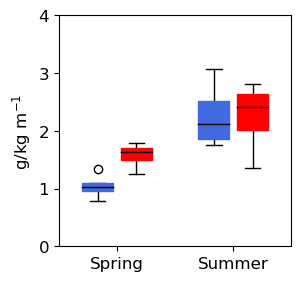

In [27]:
## Preliminary figure 3a

def color_boxplot(data, color, pos=[0], ax=None):
    ax = ax or plt.gca()
    bp = ax.boxplot(data, patch_artist=True,  showmeans=False, positions=pos,widths=0.4)
    for item in ['boxes']:
        plt.setp(bp[item], color=color)
    for item in ['whiskers', 'fliers', 'medians', 'caps']:
        plt.setp(bp[item], color='k')


data1 = [Spring_C]
data2 = [Spring_W]
data3 = [Summer_C]
data4 = [Summer_W]

fig, ax = plt.subplots(figsize=(3,3))
bp1 = color_boxplot(data1, 'royalblue', [1])
bp2 = color_boxplot(data2, 'r', [1.5])
bp3 = color_boxplot(data3, 'royalblue', [2.5])
bp4 = color_boxplot(data4, 'r', [3])
#ax.autoscale()
ax.set(xticks=[1.25,2.75], xticklabels=['Spring','Summer'])
ax.set_ylim(0,4)
ax.set_ylabel('g/kg m$^{-1}$')
#ax.legend([bp1["boxes"], bp2["boxes"], ['A', 'B'], loc='upper right')
plt.show()

In [28]:
Spring_C.mean()

1.0410794959463128

In [29]:
Spring_W.mean()

1.5727464519345842

### t tests for differences between spring and summer of cold and warm years

In [30]:
stats.ttest_ind(a=Spring_C, b=Spring_W, equal_var=True)

Ttest_indResult(statistic=-3.2549854731346284, pvalue=0.017357515838305776)

In [31]:
stats.ttest_ind(a=Summer_C, b=Summer_W, equal_var=True)

Ttest_indResult(statistic=0.03653455199313131, pvalue=0.9720413153423364)